# CHIPS-CVN Example Notebook

## Get Example ROOT Hit Maps

Firstly we must download some data to work with. We will download some beam $\nu_{e}$ and $\nu_{\mu}$ charged-current (CC), quasi-elastic (QEL) events. There are 20000 events for each, which will be stored in ./example_data (everything in this notebook assumes this relative path).

In [1]:
!mkdir example_data
!wget -q --show-progress -P example_data http://www.hep.ucl.ac.uk/~jtingey/beam_nuel_qel_cc.tar
!tar -C example_data -xf example_data/beam_nuel_qel_cc.tar
!rm example_data/beam_nuel_qel_cc.tar
!wget -q --show-progress -P example_data http://www.hep.ucl.ac.uk/~jtingey/beam_numu_qel_cc.tar
!tar -C example_data -xf example_data/beam_numu_qel_cc.tar
!rm example_data/beam_numu_qel_cc.tar

beam_nuel_qel_cc.ta 100%[===================>] 230.23M   112MB/s    in 2.1s    
beam_numu_qel_cc.ta 100%[===================>] 217.92M   112MB/s    in 1.9s    


## Setup the GPUs

We need to first initialise the GPUs

In [2]:
import chipscvn.utils as utils
utils.gpu_setup()  # Setup the GPU's

---  3 Physical GPUs, 3 Logical GPUs ---


## Convert ROOT Hit Maps to tfrecords

We first convert the ROOT hit map files into .tfrecords files, so Tensorflow (TF) can load them on-the-fly when training. These contain serialised "examples" containing "features" and "labels". We also split the data into TRAIN, VALIDATION and TEST sets. The DataCreator class in the data module does this (by default it does this in parralel)

In [3]:
import chipscvn.data as data

# Firstly beam_nuel_qel_cc (input_directory, geometry_name, test/val fraction, join, single_thread)
print("Processing nuel events...")
nuel_creator = data.DataCreator("./example_data/beam_nuel_qel_cc", "chips_1200_sk1pe", 0.1, 10, True)
nuel_creator.preprocess()

# Secondly beam_numu_qel_cc (input_directory, geometry_name, test/val fraction, join, single_thread)
print("Processing numu events...")
numu_creator = data.DataCreator("./example_data/beam_numu_qel_cc", "chips_1200_sk1pe", 0.1, 10, True)
numu_creator.preprocess()

Processing nuel events...
Processing job 0...
Processing numu events...
Processing job 0...


## The Configuration File

Everything in chips-cvn is controlled by a YAML (YAML Ain't Markup Language) configuration file, which is similar to JSON. This makes dealing with the large amount of possible parameters much, much easier. The file is split into different sections for the different functional sections of the code.

In [4]:
!cat config/example_energy_estimation.yml  # Look at the example energy estimation configuration file

---
exp: # Variables that define the experiment
    name: "energy_estimation_example"
    experiment_dir: "experiments/"
data: # Variables used to load the data
    input_dirs: 
        - "example_data/beam_nuel_qel_cc/tf/chips_1200_sk1pe/"
    img_shape: [64, 64, 3]
    batch_size: 64
    max_examples: 2500
model: # Variables used in building the model
    name: "single_par"
    parameter: "lepEnergy"
    lr: 0.001
    dense_units: 256
    dropout: 0.0
    kernel_size: 3
    filters: 64
trainer: # Variables used by the trainer
    num_epochs: 5
    es_delta: 5
    es_epochs: 5
study: # We list the number of trials and then all the variables we want to tune
    trials: 200
    data:
        batch_size: [32, 64, 128]
    model:
        lr: [0.0005, 0.01]
        dense_units: [64, 128]
        dropout: [0.0, 0.5]
        kernel_size: [3, 5]
        filters: [32, 64, 128]
eval: # Variables used by the evaluator
    input_dirs: 
        - "example_data/beam_nuel_qel_cc/tf/chips_1200_sk1pe/

## Look at an Event

To inspect some example events we will use the "DataLoader" from the data module that creates TF datasets from the .tfrecords files and just look at a few events and what they contain. Each "example" in the dataset is a tuple of two things the "image" and the "labels".

In [10]:
import matplotlib.pyplot as plt
import chipscvn.config as config

conf = config.process_config("config/example_energy_estimation.yml")  # Load the example configuration
data_loader = data.DataLoader(conf)  # Setup the DataLoader using the configuration

dataset = data_loader.train_data()  # Get the training dataset from the DataLoader
for example in dataset.take(1):  # Dataset is iterable, take first batch of 64 examples
    print("Batch type: " + str(type(example)) + ", Elements: " + str(len(example)))
    print(example[0].keys())  # Print the image tensor shape
    print(example[0]["image"].shape)  # Print the image tensor shape
    print(example[1].keys())  # Print the labels dictionary keys

Batch type: <class 'tuple'>, Elements: 2
dict_keys(['image', 'vtxX', 'vtxY', 'vtxZ', 'dirTheta', 'dirPhi'])
(64, 64, 64, 3)
dict_keys(['pdg', 'type', 'category', 'vtxX', 'vtxY', 'vtxZ', 'dirTheta', 'dirPhi', 'nuEnergy', 'lepEnergy'])


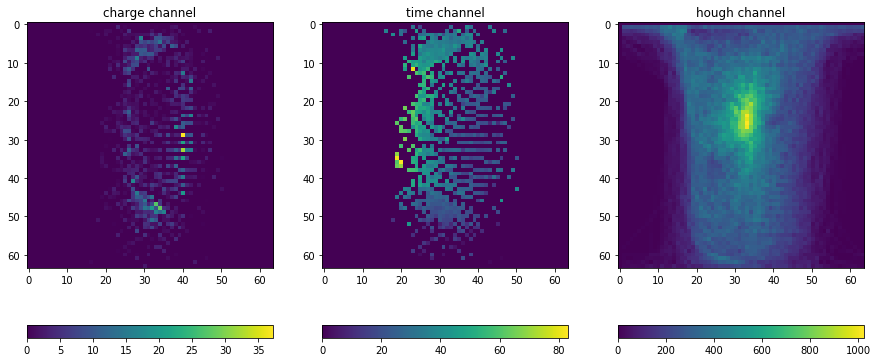

In [11]:
for example in dataset.take(1):  # Dataset is iterable, take first batch of 64 examples
    image = example[0]["image"][0].numpy()  # Get the first "image" in the batch
    charge, time, hough = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    
    plt.figure(1, figsize=(15, 7))
    plt.subplot(131)
    plt.title('charge channel')
    plt.imshow(charge)
    plt.colorbar(orientation='horizontal')

    plt.subplot(132)
    plt.title('time channel')
    plt.imshow(time)
    plt.colorbar(orientation='horizontal')
    
    plt.subplot(133)
    plt.title('hough channel')
    plt.imshow(hough)    
    plt.colorbar(orientation='horizontal')
    
    plt.show()

## Train a Simple Energy Estimation Network

As a first example we will train a simple Convolutional Neural Network to estimate the $\nu_{e}$ energy in $\nu_{e}$ QEL-CC events.

Model: "single_par_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 128)  

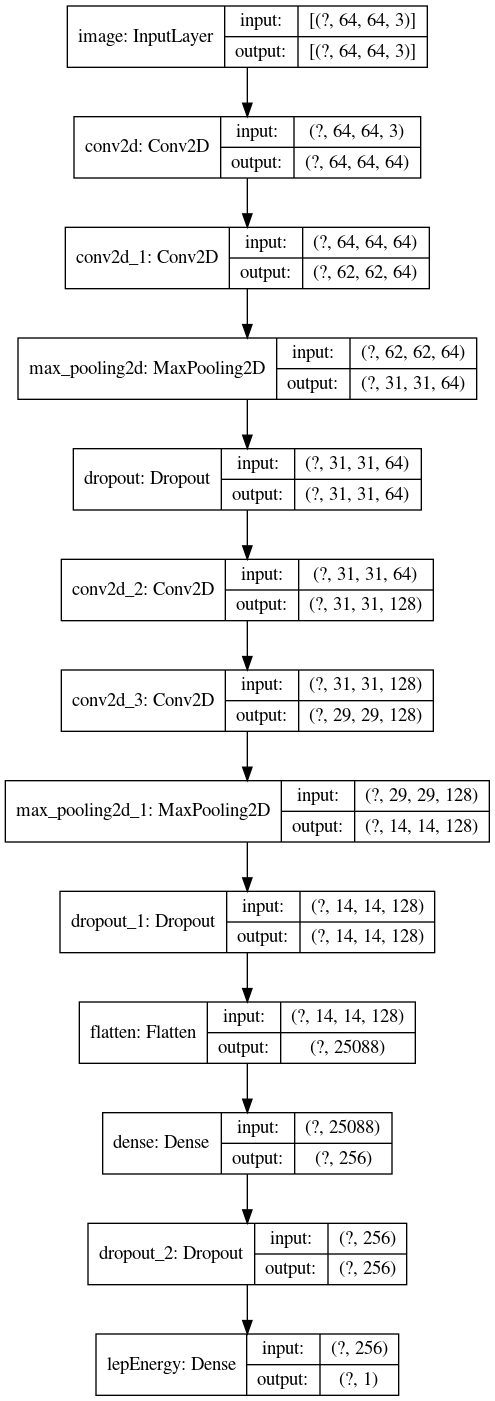

In [12]:
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.trainers as trainer

conf = config.process_config("config/example_energy_estimation.yml") # Load the example configuration
data_loader = data.DataLoader(conf)                                  # Setup the TF datasets
model = utils.get_model(conf)                                        # Create the model
model.summarise()                                                    # Print model summary

from IPython.display import Image
Image("experiments/energy_estimation_example/model_diagram.png")

In [13]:
model_trainer = utils.get_trainer(conf, model, data_loader)          # Setup the model trainer
model_trainer.train()                                                # Train the model

Epoch 1/5
246/246 [==============================] - 10s 39ms/step - loss: 709317.0053 - mae: 570.0886 - mse: 709317.0625 - val_loss: 234450.0255 - val_mae: 354.7711 - val_mse: 234450.0312
Epoch 2/5
246/246 [==============================] - 6s 25ms/step - loss: 195306.6670 - mae: 312.4088 - mse: 195306.6562 - val_loss: 208700.3690 - val_mae: 331.7112 - val_mse: 208700.3594
Epoch 3/5
246/246 [==============================] - 6s 25ms/step - loss: 168271.5789 - mae: 287.0947 - mse: 168271.5938 - val_loss: 182667.0357 - val_mae: 315.2984 - val_mse: 182667.0469
Epoch 4/5
246/246 [==============================] - 6s 25ms/step - loss: 153705.6384 - mae: 272.1570 - mse: 153705.6094 - val_loss: 258637.5495 - val_mae: 403.4972 - val_mse: 258637.5625
Epoch 5/5
246/246 [==============================] - 6s 25ms/step - loss: 147581.7368 - mae: 268.7666 - mse: 147581.7500 - val_loss: 252369.1823 - val_mae: 391.7605 - val_mse: 252369.1562


## Test the train model

Whenever you run a training "experiment" chips-cvn creates a directory containing various outputs in the ./experiments directory.

- Model weights, saved at the end of each epoch
- Tensorboard files
- Image of the model structure

We can now test the model on the test dataset by loading the trained model and evaluating its performance. We will not load the model here as we already have it fully trained in memory...

In [14]:
import ROOT
from root_numpy import fill_hist
import chipscvn.evaluators as evaluators
%jsroot on

evaluator = utils.get_evaluator(conf)          # Setup the model evaluator
evaluator.run()                                # Run the evaluator
labels, predictions = evaluators.predict(data_loader.test_data(), model)
diff = labels['lepEnergy'] - predictions['lepEnergy']
diff = diff.to_numpy()
h = ROOT.TH1F("resolution_h","resolution",50,-800,800)
h.GetXaxis().SetTitle("True-reco Lepton Energy");
h.GetYaxis().SetTitle("Frequency");
fill_hist(h, diff)
c = ROOT.TCanvas("resolution_c","resolution",800,600)
h.Draw()
c.Draw()

Welcome to JupyROOT 6.18/04
--- 1.1235084533691406 seconds to test model ---


## Train a Simple Classification Network

We will now train a simple classification network to distinguish $\nu_{e}$ QEL-CC events from $\nu_{e}$ QEL-CC events.

In [15]:
import chipscvn.config as config
import chipscvn.data as data
import chipscvn.models as models
import chipscvn.trainers as trainer

conf = config.process_config("config/example_classification.yml")    # Load the example configuration
data_loader = data.DataLoader(conf)                                  # Setup the TF datasets
model = utils.get_model(conf)                                        # Create the model

Model: "classification_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 64, 64, 64)   1792        image[0][0]                      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 62, 62, 64)   36928       conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 31, 31, 64)   0           conv2d_9[0][0]                   
_______________________________________________________________________________

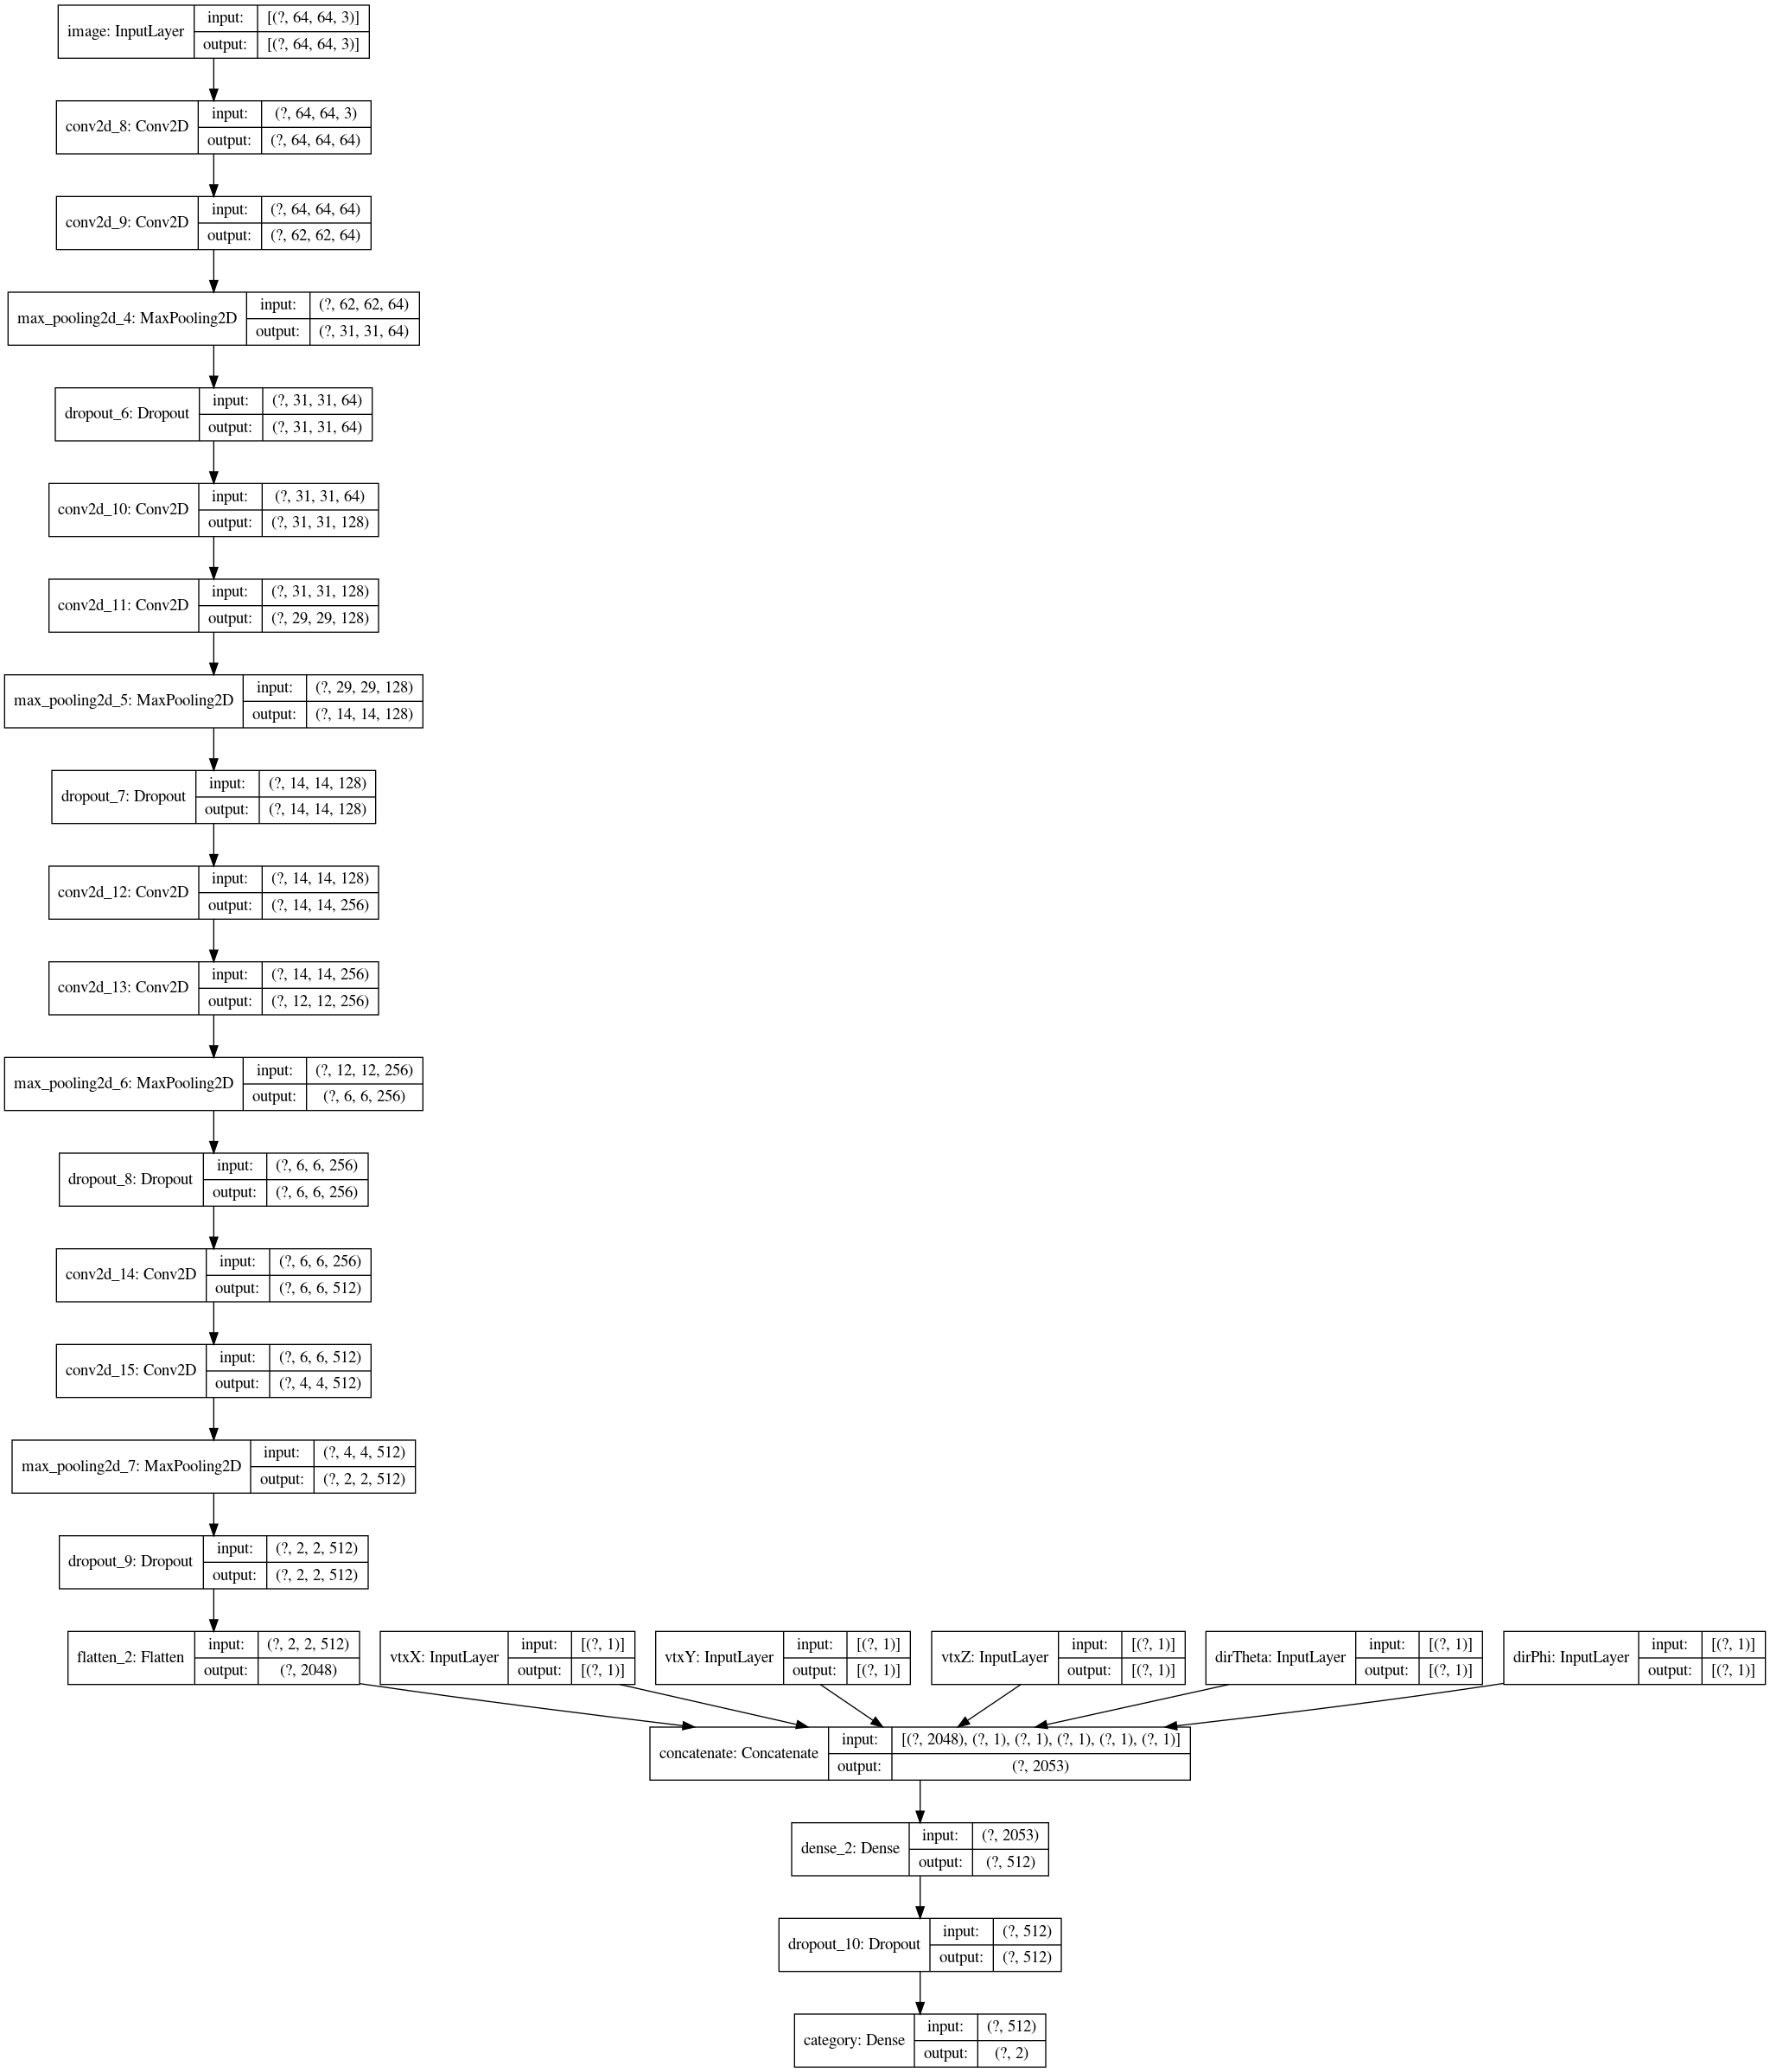

In [16]:
model.summarise()                                                    # Print model summary
from IPython.display import Image
Image("experiments/classification_example/model_diagram.png")

In [17]:
model_trainer = utils.get_trainer(conf, model, data_loader)          # Setup the model trainer
model_trainer.train()                                                # Train the model

Epoch 1/3
488/488 [==============================] - 18s 36ms/step - loss: 2.9192 - accuracy: 0.6392 - val_loss: 1.0742 - val_accuracy: 0.7336
Epoch 2/3
488/488 [==============================] - 16s 33ms/step - loss: 0.1870 - accuracy: 0.9302 - val_loss: 1.0073 - val_accuracy: 0.6878
Epoch 3/3
488/488 [==============================] - 16s 33ms/step - loss: 0.1387 - accuracy: 0.9457 - val_loss: 0.2565 - val_accuracy: 0.9083


2020-02-12 14:42:16.080018: I tensorflow/core/profiler/lib/profiler_session.cc:225] Profiler session started.
2020-02-12 14:42:16.080072: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1307] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2020-02-12 14:42:16.080083: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1346] function cupti_interface_->ActivityRegisterCallbacks( AllocCuptiActivityBuffer, FreeCuptiActivityBuffer)failed with error CUPTI could not be loaded or symbol could not be found.
2020-02-12 14:42:16.112368: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1329] function cupti_interface_->EnableCallback( 0 , subscriber_, CUPTI_CB_DOMAIN_DRIVER_API, cbid)failed with error CUPTI could not be loaded or symbol could not be found.
2020-02-12 14:42:16.112393: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:88]  GpuTracer has collect

In [18]:
import chipscvn.evaluators as evaluators
evaluator = utils.get_evaluator(conf)
evaluator.run()
labels, predictions = evaluators.predict(data_loader.test_data(), model)

--- 2.856715202331543 seconds to test model ---


In [19]:
import numpy as np

def prediction_classifier(row):
    return np.asarray(row["category"]).argmax()
        
predictions['category'] = predictions.apply(prediction_classifier, axis=1)
labels["category"] = labels["category"].astype('int')
predictions["category"] = predictions["category"].astype('int')

In [20]:
labels.head()

,pdg,type,category,vtxX,vtxY,vtxZ,dirTheta,dirPhi,nuEnergy,lepEnergy
0,0,0,0,256.879669,436.601257,320.823059,-0.198050,13.959404,3907.239990,3066.860107
1,1,0,1,-1010.002380,-112.537506,277.013733,-0.205720,9.465075,6039.870117,4646.609863
2,0,0,0,-189.640213,820.103210,344.603943,0.429937,-19.401566,2750.300049,1863.459961
3,1,0,1,33.860981,370.914612,240.226227,0.175444,-8.323520,5112.759766,4431.049805
4,0,0,0,603.301880,320.309448,-333.757874,0.166436,7.235719,2754.530029,2579.169922


In [21]:
predictions.head()

,category
0,0
1,1
2,0
3,1
4,0


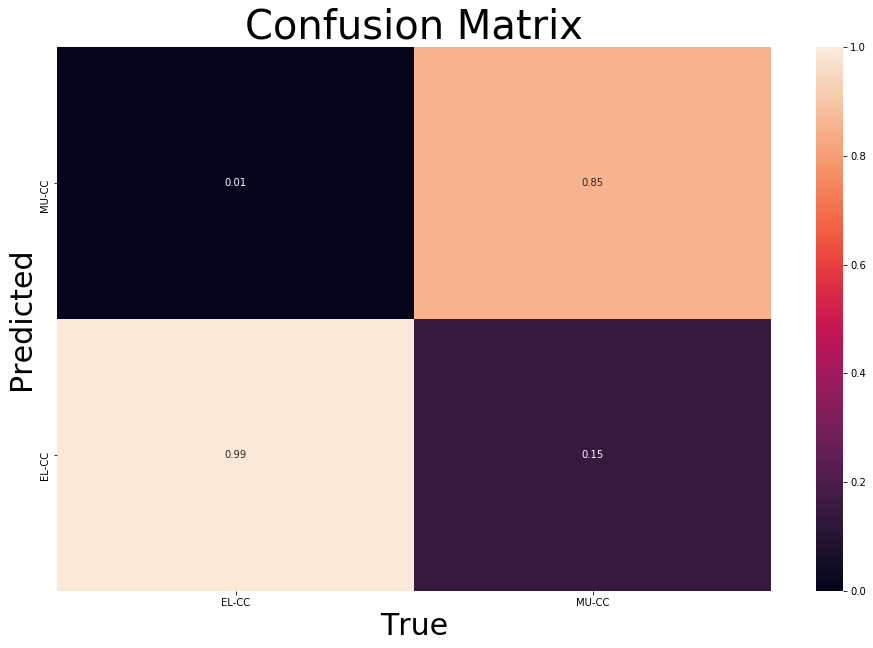

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
matrix = confusion_matrix(labels["category"], predictions["category"], normalize='true')
matrix_transpose = np.rot90(matrix, 1)
df_cm = pd.DataFrame(matrix_transpose, 
                     index = ["MU-CC", "EL-CC"],
                     columns = ["EL-CC", "MU-CC"])
plt.figure(figsize=(16,10))
sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0)
plt.title('Confusion Matrix', fontsize = 40) # title with fontsize 20
plt.xlabel('True', fontsize = 30) # x-axis label with fontsize 15
plt.ylabel('Predicted', fontsize = 30) # y-axis label with fontsize 15
plt.show()